In [1]:
import os
import torch
import torchaudio
import augment
import numpy as np
import pandas as pd
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

/nfs/homedirs/yuny/miniconda3/envs/project/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
annotation_path = '/nfs/students/winter-term-2020/project-1/datasets/BMW/meta/bmw.csv'
if os.path.isfile(annotation_path):
    csv_data = pd.read_csv(annotation_path)

BMW sample of class 3, sample rate 48000 and length 245760


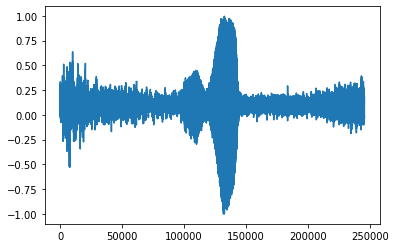

In [3]:
# pick a random sample from the BMW dataset
idx = 100 #100
x, sr = torchaudio.load(csv_data.loc[idx, 'slice_file_name'])
print('BMW sample of class %s, sample rate %d and length %d' %(csv_data.loc[idx, 'classID'], sr, x.size(1)))
plt.plot(x.cpu().numpy().flatten())
plt.show()
ipd.Audio(x, rate=sr)

Delay:


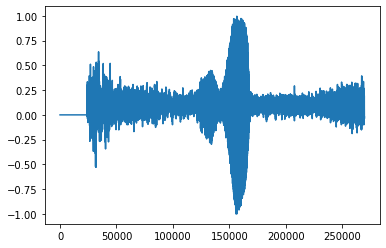

Tempo:


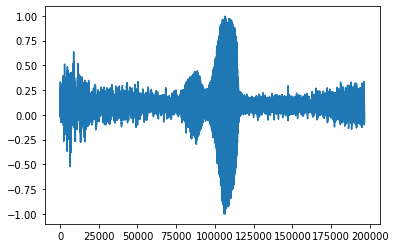

Pitch shift:


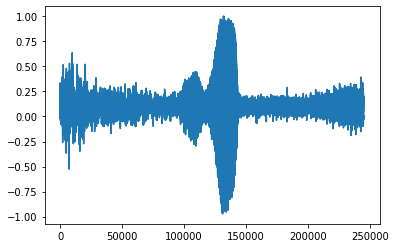

Reverberation:


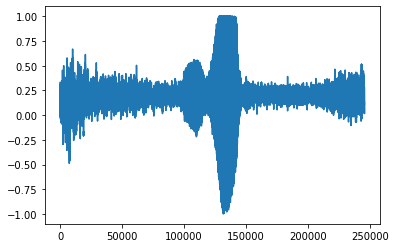

Additive Uniform Noise:


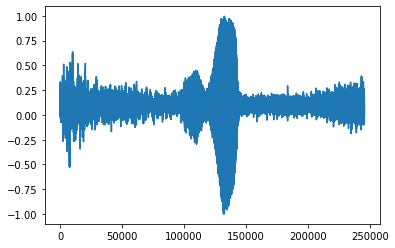

In [4]:
# Demo several different types of transformations
def augment_audio(original, effect_chain):
    y = effect_chain.apply(x, src_info={'rate': sr})
    plt.plot(y.cpu().numpy().flatten())
    plt.show()
    return y

    
print("Delay:")
# Delay the audio by 0.5 seconds
chain = augment.EffectChain().delay(0.5)
y = augment_audio(x, chain)
ipd.Audio(y, rate=sr)

print("Tempo:")
# Play the audio faster at 2* without changing the pitch
chain = augment.EffectChain().tempo("-q", 1.25)
y = augment_audio(x, chain)
ipd.Audio(y, rate=sr)
    
print("Pitch shift:")
# lowered the pitch of the voice by 2 tones: -200 indicates that we'll go lower by 200 cents of the tone.
chain = augment.EffectChain().pitch(200).rate(sr)
y = augment_audio(x, chain)
ipd.Audio(y, rate=sr)

print("Reverberation:")
# reverberations are specified by three parameters: reverberance, dumping factor, and room size.
chain = augment.EffectChain().reverb(50, 50, 50).channels(1)
y = augment_audio(x, chain)
ipd.Audio(y, rate=sr)

print("Additive Uniform Noise:")
noise_generator = lambda: torch.zeros_like(x).uniform_()
chain = augment.EffectChain().additive_noise(noise_generator, snr=30)
y = augment_audio(x, chain)
ipd.Audio(y, rate=sr)

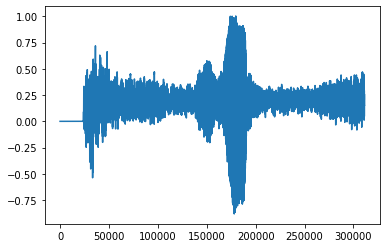

In [5]:
x, sr = torchaudio.load(csv_data.loc[idx, 'slice_file_name'])
# randomly transform the audio clip with pitch shift, reverberation and addtive noise
# random_delay_seconds = lambda: np.random.uniform(0, 1)
random_tempo_ratio = lambda: np.random.uniform(0.75, 1.25)
random_pitch_shift = lambda: np.random.randint(-200, +200)
random_room_size = lambda: np.random.randint(0, 101)
# noise_generator = lambda: torch.zeros_like(x).uniform_()
combination = augment.EffectChain() \
    .tempo("-q", random_tempo_ratio) \
    .pitch("-q", random_pitch_shift).rate(sr) \
    .reverb(50, 50, random_room_size).channels(1) \
#     .delay(random_delay_seconds) \
#     .additive_noise(noise_generator, snr=50)
y = combination.apply(x, src_info={'rate': sr}, target_info={'rate': sr})
plt.plot(y.cpu().numpy().flatten())
plt.show()
ipd.Audio(y, rate=sr)

In [6]:
import yaml
from audio_classification.utils import get_augment
from audio_classification.tools import get_transform
from audio_classification.data import BMWDataset
with open("/nfs/homedirs/yuny/project-1/audio_classification/configs/crnn_bmw.yaml", "r") as config_file:
    configs = yaml.load(config_file)
audio_set = BMWDataset(configs, [1], transform=None, augment=get_augment(configs)) 
spec_set = BMWDataset(configs, [1], transform=get_transform(configs), augment=get_augment(configs)) 

/nfs/homedirs/yuny/miniconda3/envs/project/lib/python3.7/site-packages/ipykernel_launcher.py:6: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


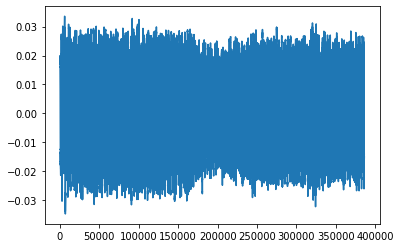

/nfs/homedirs/yuny/miniconda3/envs/project/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/nfs/homedirs/yuny/miniconda3/envs/project/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


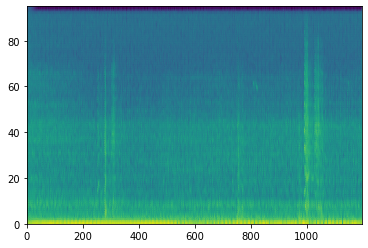

In [7]:
# Visualize some random sample from BMW dataset
idx = 0
audio = audio_set.__getitem__(idx)
plt.plot(audio[0].cpu().numpy().flatten())
plt.show()
spec = spec_set.__getitem__(idx)
plt.pcolormesh(spec[0].squeeze().numpy(), shading='gouraud')
plt.show()